In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def draw_graph(nodes, edges, adj_list, positions=list(), axis=False, node_size=3):
    #https://distill.pub/2021/gnn-intro/
    #nodes = values of nodes
    #edges = values of edges
    #adj_list = which edges connects which nodes, e.g if adj_list[3]=(1, 5) then the third edge in edges connects node 1 and 5
    num_nodes = len(nodes)
    pos_given = len(positions)>0
    if pos_given and num_nodes != len(positions):
        print("hoppala")
        return -1
    
    num_edges = len(edges)
    if num_edges != len(adj_list):
        print("ups")
        return -1

    G = nx.Graph()
    for n in range(num_nodes):
        if pos_given:
            G.add_node(n, n_value=nodes[n], pos=positions[n])
        else:
            G.add_node(n, n_value=nodes[n])
    for e in range(num_edges):
        G.add_edge(adj_list[e][0], adj_list[e][1], e_value=edges[e])

    pos_nodes =nx.get_node_attributes(G,'pos')

    if axis:
        fig = plt.figure()
        ax = fig.add_subplot()
        if pos_given:
            nx.draw(G, pos=pos_nodes, ax=ax, node_size=node_size)
        else:
            nx.draw(G, ax=ax, node_size=node_size)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.axis('on')
    else:
        if len(positions)>0:
            nx.draw(G, pos=pos_nodes, node_size=node_size)
        else:
            nx.draw(G, node_size=node_size)

In [3]:
def genLattice(len_ex, len_ey, frac_theta, nx_max=20, ny_max=20, hexagonal=False, remove_center=False):
    '''
    Nummerierung nodes:
    8   9   ....
    4   5   6   7
    0   1   2   3
    '''
    theta = 2*np.pi/frac_theta
    e_x = len_ex*np.array([1, 0], dtype=float)
    e_y = len_ey*np.array([np.cos(theta), np.sin(theta)], dtype=float)
    num_nodes = nx_max*ny_max

    #indices
    ind_pos = np.zeros(shape=(num_nodes, 2))
    ind_pos[:, 0] = np.tile(np.arange(0, nx_max), ny_max)
    ind_pos[:, 1] = np.array([nx_max*[y] for y in range(ny_max)]).flatten()

    #positions
    pos = np.zeros(shape=(num_nodes, 2))
    for n in range(num_nodes):
        pos[n, :] = ind_pos[n, 0]*e_x + ind_pos[n, 1]*e_y

    #edges, adj_list
    adj_list = np.array([])
    num_edges = 0

    if hexagonal==True:
        num_edges = ny_max*(nx_max - 1) + nx_max*(ny_max - 1) + (nx_max-1)*(ny_max-1)
        adj_list = np.zeros(shape=(num_edges, 2), dtype=int)
        ind_edge = 0
        for x in range(0, nx_max):
            for y in range(0, ny_max):
                ind_center = y*nx_max + x
                ind = [ind_center, ind_center + nx_max, ind_center + 1, ind_center + nx_max + 1] #center, up, right, diag
                edge_possible = [True, True, True] #up, right
                if x == nx_max - 1:
                    edge_possible[1] = False
                    edge_possible[2] = False
                if y == ny_max - 1:
                    edge_possible[0] = False
                    edge_possible[2] = False
                for dir in range(3):
                    if edge_possible[dir]:
                        adj_list[ind_edge] = [ind[0], ind[dir + 1]]
                        ind_edge += 1
    else:
        num_edges = ny_max*(nx_max - 1) + nx_max*(ny_max - 1)
        adj_list = np.zeros(shape=(num_edges, 2), dtype=int)
        ind_edge = 0
        for x in range(0, nx_max):
            for y in range(0, ny_max):
                ind_center = y*nx_max + x
                ind = [ind_center, ind_center + nx_max, ind_center + 1] #center, up, right
                edge_possible = [True, True] #up, right
                if x == nx_max - 1:
                    edge_possible[1] = False
                if y == ny_max - 1:
                    edge_possible[0] = False
                for dir in range(2):
                    if edge_possible[dir]:
                        adj_list[ind_edge] = [ind[0], ind[dir + 1]]
                        ind_edge += 1
    
    if remove_center:
        pos_to_remove = list()
        for x in range(0, nx_max):
            y_off = (3-x) % 3
            for y in range(y_off, ny_max, 3):
                pos_to_remove.append([x, y])
        ind_to_remove = list([pos[0] + pos[1]*nx_max for pos in pos_to_remove])
        mask = np.array([i in ind_to_remove for i in range(num_nodes)]) #True if element should be removed
        mask_edges = np.array([((e[0] in ind_to_remove) or (e[1] in ind_to_remove)) for e in adj_list]) #True if edge should be removed

        adj_list = adj_list[~mask_edges]
        num_edges -= np.count_nonzero(mask_edges)
        num_nodes -= np.count_nonzero(mask)

        for e in adj_list: #shift (deleting nodes = indices of nodes change)
            e[0] -= np.count_nonzero(mask[:e[0]])
            e[1] -= np.count_nonzero(mask[:e[1]])
            
        pos = pos[~mask]
    
    return num_nodes, num_edges, adj_list, pos

In [4]:
def addNoise(pos, mu, sigma, scale):
    pos_ = pos + scale*np.random.normal(mu, sigma, size=pos.shape)
    return pos_

In [5]:
def rotateLattice(pos, alpha):
    rotMat = np.array(
        [[np.cos(alpha), -np.sin(alpha)], 
        [np.sin(alpha), np.cos(alpha)]])
    pos_ = np.zeros(shape=pos.shape)
    for i in range(len(pos)):
        pos_[i, :] = np.matmul(rotMat, pos[i, :])
    return pos_

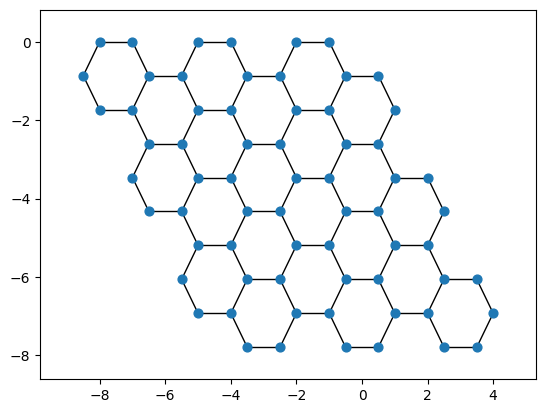

In [10]:
num_nodes, num_edges, adj_list, pos = genLattice(1, 1, 3, nx_max=10, ny_max=10, hexagonal=True, remove_center=True)
pos_ = addNoise(pos, 0, 0.5, 0)
pos_ = rotateLattice(pos_, 2*np.pi/2)

values_nodes = np.arange(num_nodes)
values_edges = np.arange(num_edges)
draw_graph(np.arange(num_nodes), np.arange(num_edges), adj_list, positions=pos_, node_size=40, axis=True)

In [46]:
a = np.array([True, False, False])
print(np.count_nonzero(a))

1
